**18장 – 강화학습**

_이 노트북은 18장에 있는 모든 샘플 코드를 담고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/18_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 코랩에서 실행하고 있나요?
IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym>=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 부드러운 애니메이션을 위해
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# OpenAI 짐 소개

이 노트북은 강화학습 알고리즘을 개발하고 평가하는 훌륭한 도구인 [OpenAI 짐(gym)](https://gym.openai.com/)을 사용합니다. 학습 에이전트가 상호작용하기 위한 환경을 많이 제공합니다. 먼저 `gym`을 임포트합니다:

In [2]:
import gym

가능한 환경 목록을 확인해 보죠:

In [3]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

Cart-Pole은 매우 간단한 환경으로 왼쪽과 오른쪽으로 움직이는 카트와 그 위에 수직으로 놓여 있는 막대로 구성됩니다. 에이전트는 카트를 왼쪽이나 오른쪽으로 움직여 막대가 바로 서 있도록 만들어야 합니다.

In [4]:
env = gym.make('CartPole-v1')

`reset()` 메서드를 호출해 환경을 초기화합니다. 이 메서드는 관측을 반환합니다:

In [5]:
env.seed(42)
obs = env.reset()

관측은 환경에 따라 다릅니다. 이 경우 4개의 실수로 구성된 1D 넘파이 배열입니다. 카트의 수평 위치, 속도, 막대의 각도(0=수직), 각속도를 나타냅니다.

In [6]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

환경은 `render()` 메서드를 호출하여 시각화할 수 있습니다. 그리고 렌더링 모드(환경에 따른 렌더링 옵션)를 선택할 수 있습니다.

**경고**: (Cart-Pole을 포함해) 일부 환경은 화면 접근 권한이 필요합니다. `mode="rgb_array"`로 지정하더라도 별도의 윈도우를 엽니다. 일반적으로 이 윈도우를 무시할 수 있습니다. 하지만 주피터를 백엔드(headless) 서버로 실행한다면 예외가 발생합니다. 이를 피하는 한 가지 방법은 [Xvfb](http://en.wikipedia.org/wiki/Xvfb) 같은 가짜 X 서버를 설치하는 것입니다. 데비안이나 우분투에서는 다음과 같이 설치합니다:

```bash
$ apt update
$ apt install -y xvfb
```

그다음 `xvfb-run` 명령으로 주피터를 실행합니다:

```bash
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

또는 Xvfb를 감싼 [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) 파이썬 라이브러리를 설치할 수 있습니다:

```bash
%pip install -U pyvirtualdisplay
```

그다음 다음 코드를 실행합니다:

In [7]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [8]:
env.render()

True

이 예에서는 `mode="rgb_array"`로 지정해 환경 이미지를 넘파이 배열로 받을 것입니다:

In [9]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [10]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

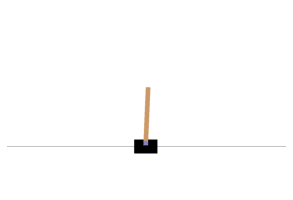

In [11]:
plot_environment(env)
plt.show()

환경과 상호작용하는 방법을 알아 보죠. 에이전트는 "행동 공간"(가능한 행동의 집합)에서 하나의 행동을 선택해야 합니다. 이 환경의 행동 공간을 다음처럼 확인해 보죠:

In [12]:
env.action_space

Discrete(2)

네 단 두 개의 행동이 가능합니다: 왼쪽 또는 오른쪽으로 가속합니다.

막대가 오른쪽으로 기울어져 있기 때문에(`obs[2] > 0`), 카트를 오른쪽으로 가속해 보죠:

In [13]:
action = 1  # 오른쪽으로 가속
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

이제 카트가 오른쪽으로 움직였습니다(`obs[1] > 0`). 막대가 여전히 오른쪽으로 기울어져 있습니다(`obs[2] > 0`). 하지만 각속도가 음수이므로(`obs[3] < 0`) 다음 스텝에서는 왼쪽으로 기울 것 같습니다.

Saving figure cart_pole_plot


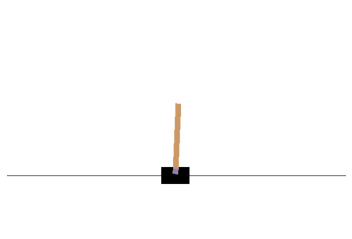

In [14]:
plot_environment(env)
save_fig("cart_pole_plot")

요청한 대로 실행되는 것 같습니다!

환경은 이전 스텝에서 얼마나 많은 보상을 받는지 에이전트에게 알려 줍니다:

In [15]:
reward

1.0

게임이 끝나면 환경은 `done=True`를 반환합니다:

In [16]:
done

False

마지막으로 `info`는 훈련이나 디버깅에 유용한 추가적인 정보를 담은 환경에 특화된 딕셔너리입니다. 예를 들어 일부 게임에서는 얼마나 많은 에이전트의 생명이 몇 개가 남아 있는지 나타낼 수 있습니다.

In [17]:
info

{}

환경이 재설정된 순간부터 종료될 때까지 스텝 시퀀스를 "에피소드"라고 합니다. 에피소드 끝에서 (즉, `step()`이 `done=True`를 반환할 때), 계속하기 전에 환경을 재설정해야 합니다.

In [18]:
if done:
    obs = env.reset()

그럼 어떻게 막대를 똑바로 유지할 수 있을까요? 이를 위해 정책을 정의해야 합니다. 에이전트가 매 스텝마다 행동을 선택하기 위해 사용할 전략입니다. 어떤 행동을 선택할지 결정하기 위해 지난 행동과 관측을 모두 사용할 수 있습니다.

# 간단한 하드 코딩 정책

간단한 정책을 하드 코딩해 보죠. 막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 움직이고 오른쪽으로 기울어지면 반대로 움직입니다. 어떻게 작동하는지 확인해 보죠:

In [19]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [20]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

예상대로 이 전략은 너무 단순합니다. 최대로 막대를 유지한 스텝 횟수가 68입니다. 이 환경은 에이전트가 막대를 200 스텝 이상 유지해야 해결된 것으로 간주합니다.

하나의 에피소드를 시각화해 보죠:

In [21]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

애니메이션을 출력합니다:

In [22]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [23]:
plot_animation(frames)

확실히 이 방법은 불안정해서 약간 흔들리면 막대가 너무 기울어져 게임이 끝납니다. 이 보다는 더 똑똑한 전략이 필요합니다!

# 신경망 정책

관측을 입력으로 받고 각 관측에 대해 선택할 행동의 확률을 출력하는 신경망을 만들어 보죠. 행동을 선택하기 위해 신경망은 각 행동의 확률을 추정합니다. 이 추정된 확률에 따라 랜덤하게 행동을 선택합니다. Cart-Pole 환경의 경우 두 개의 가능한 행동이 있습니다(왼쪽과 오른쪽). 따라서 하나의 출력 뉴런만 있으면 됩니다. 이 뉴런은 행동 0(왼쪽)의 확률 `p`를 출력합니다. 물론 행동 1(오른쪽)의 확률은 `1 - p`가 됩니다.

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

이 환경에서는 지난 행동과 관측을 무시할 수 있습니다. 각 관측이 완전한 환경의 상태를 담고 있기 때문입니다. 은닉 상태가 있다면 환경의 은닉 상태를 추정하기 위해 지난 행동과 관측을 고려해야 할 수 있습니다. 예를 들어, 이 환경이 카트의 위치만 제공하고 속도를 알려 주지 않는다면, 현재 속도를 추정하기 위해 현재 관측 뿐만 아니라 지난 관측도 고려해야 합니다. 또 다른 예는 관측에 잡음이 있는 경우입니다. 가장 가능성 있는 현재 상태를 추정하기 위해 지난 몇 개의 관측을 사용할 수 있습니다. 이 문제는 매우 간단합니다. 현재 관측에 잡음이 없고 환경의 모든 상태가 담겨 있습니다.

정책 네트워크가 출력한 확률 중에서 가장 높은 확률을 가진 행동을 선택하지 않고 랜덤한 행동을 선택하는 이유가 궁금할지 모릅니다. 이 방법은 에이전트가 새로운 행동을 탐험하는 것과 잘 동작하는 행동을 활용하는 것 사이에 밸런스를 찾도록 합니다. 비유를 들어 보죠. 한 음식점에 처음 방문했다고 가정해 보죠. 모든 음식에 대한 선호도가 동일하다면 랜덤하게 하나를 선택합니다. 이 음식이 좋다고 느낀다면 다음 번에 이 음식을 주문할 확률을 높일 수 있습니다. 하지만 이 확률을 100%로 높여서는 안됩니다. 그렇지 않으면 다른 음식을 시도해 볼 수 없습니다. 어쩌면 다른 음식이 이번에 먹은 것보다 훨씬 더 좋을 수도 있습니다.

모델을 실행하여 한 에피소드를 플레이하고 애니메이션을 위한 프레임을 반환하는 함수를 작성해 보죠:

In [25]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

랜덤하게 초기화된 정책 네트워크가 얼마나 잘 수행하는지 확인해 보죠:

In [26]:
frames = render_policy_net(model)
plot_animation(frames)

음.. 아주 나쁘군요. 이 신경망은 더 배워야 합니다. 먼저 앞에서 사용한 기본적인 정책을 학습할 수 있는지 확인해 보죠. 막대가 왼쪽으로 기울면 왼쪽으로 움직이고, 오른쪽으로 기울면 오른쪽으로 움직이도록 합니다.

같은 신경망으로 동시에 50개의 다른 환경을 플레이할 수 있습니다(이렇게 하면 각 스텝마다 다양한 훈련 배치를 얻을 수 있습니다). 그리고 5000번 반복 동안에 훈련합니다. 게임이 종료되면 환경을 재설정합니다. 사용자 정의 훈련 루프를 사용하여 모델을 훈련하기 때문에 훈련 스텝마다 환경에 앞서 예측을 쉽게 만들 수 있습니다.

In [27]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.094

In [28]:
frames = render_policy_net(model)
plot_animation(frames)

정책을 잘 학습한 것 같군요. 이제 스스로 더 나은 정책을 학습할 수 있는지 확인해 보겠습니다.

# 정책 그레이디언트

이 신경망을 훈련하려면 타깃 확률 `y`를 정의해야 합니다. 행동이 좋으면 해당 확률을 증가시키고 반대로 나쁘면 감소시켜야 합니다. 하지만 행동이 좋은지 나쁜지 어떻게 알까요? 대부분 행동의 효과가 지연되어 나타나기 때문에 한 에피소드에서 점수를 얻거나 잃을 때 어떤 행동이 이 결과에 기여했는지 명확하지 않다는 것이 문제입니다. 마지막 행동일까요? 아니면 마지막에서 10번째 행동일까요? 아니면 50 스텝 이전의 행동일까요? 이를 _신용 할당 문제_ 라고 부릅니다.

_정책 그레이디언트_ 알고리즘은 이 문제를 해결하기 위해 먼저 여러 개의 에피소드를 플레이하고 그다음 좋은 에피소드에 있는 행동의 가능성을 조금 더 높이고, 나쁜 에피소드에 있는 행동의 가능성을 조금 낮춥니다. 먼저 플레이해보고 다시 돌아가서 수행한 작업을 생각해 보겠습니다.

이 모델을 사용해 하나의 스텝을 플레이하는 함수를 만듭니다. 지금은 선택한 행동이 모두 좋다고 가정하고 손실과 그레이디언트를 계산합니다(그레이디언트를 저장하고 나중에 행동이 좋은지 나쁜지에 따라 수정하겠습니다):

In [29]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

`left_proba`가 높으면 `action`이 `False`가 될 가능성이 높습니다(0~1 사이에서 균등 분포로 난수를 샘플링하면 `left_proba`보다 높지 않을 가능성이 높기 때문에). 그리고 `False`를 숫자로 바꾸면 0이므로 `y_target`은 1 - 0 = 1입니다. 다른 말로 하면 타깃을 1로 지정하는 것은 왼쪽일 확률을 100%로 가정한다는 의미입니다(따라서 올바른 행동을 선택했습니다).

이제 `play_one_step()` 함수를 사용해 여러 개의 에피소드를 플레이하고 에피소드와 스텝마다 모든 보상과 그레이디언트를 반환하는 또 다른 함수를 만들어 보죠:

In [30]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

정책 그레이디언트 알고리즘은 모델을 사용해 여러 번 에피소드를 플레이합니다(예를 들어 10번). 그다음 모든 보상을 할인하고 정규화합니다. 이를 위한 함수를 만들어 보죠. 첫 번째 함수는 할인된 보상을 계산합니다. 두 번째 함수는 여러 에피소드에 걸쳐 할인된 보상을 정규화합니다.

In [31]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

3개의 행동을 수행하고 각 행동의 보상이 10, 0, -50이라고 가정해 보죠. 80%의 할인 계수를 사용하면 세 번째 행동은 -50(마지막 보상의 100%)를 받지만 두 번째 행동은 -40(마지막 보상의 80%)만 받습니다. 그리고 첫 번째 행동은 -40의 80%(-32)에 첫 번째 보상(+10)의 100%를 받습니다. 따라서 할인된 보상의 합은 -22가 됩니다:

In [32]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

전체 에피소드에 대해 모든 할인된 보상을 정규화하기 위해 전체 할인된 보상의 평균과 표준 편차를 계산합니다. 그리고 할인된 보상에서 평균을 빼고 표준 편차를 나눕니다:

In [33]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [34]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [35]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [37]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 199.6

In [38]:
frames = render_policy_net(model)
plot_animation(frames)

# 마르코프 연쇄

In [39]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


# 마르코프 결정 과정

전이 확률, 보상, 가능한 행동을 정의해 보죠. 예를 들어, 상태 s0에서 행동 a0가 선택되면 0.7의 확률로 상태 s0로 가고 +10 보상을 받습니다. 그리고 0.3의 확률로 상태 s1으로 가고 보상이 없습니다. 상태 s2로는 이동하지 않습니다(따라서 전이 확률은 `[0.7, 0.3, 0.0]`이고 보상은 `[+10, 0, 0]`입니다):

In [40]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Q-가치 반복

In [41]:
Q_values = np.full((3, 3), -np.inf) # 불가능한 행동은 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 모든 가능한 행동에 대해

In [42]:
gamma = 0.90  # 할인 계수

history1 = [] # 책에는 없음
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # 책에는 없음
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # 책에는 없음

In [43]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [44]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

할인 계수 0.9를 사용했을 때 이 MDP의 최적 정책은 상태 s0에서 행동 a0를 선택하고, 상태 s1에서 행동 a0를 선택하고, 마지막으로 상태 s2에서 행동 a1(선택 가능한 유일한 행동)을 선택하는 것입니다.

할인 계수 0.95로 시도해 보죠:

In [45]:
Q_values = np.full((3, 3), -np.inf) # 불가능한 행동에 대해서는 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 모든 가능한 행동에 대해서

In [46]:
gamma = 0.95  # 할인 계수

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [47]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [48]:
np.argmax(Q_values, axis=1)

array([0, 2, 1])

이제 정책이 바뀌었습니다! 상태 s1에서 불 속으로 들어가는 것을 선택합니다(행동 a2). 할인 계수가 크기 때문에 에이전트가 미래에 더 많은 가치를 두기 때문에 미래 보상을 얻기 위해 당장의 불이익을 감내합니다.

# Q-러닝

Q-러닝은 에이전트의 (예를 들면, 랜덤한) 플레이를 보고 점진적으로 Q-가치 추정을 향상합니다. 정확한 (또는 충분히 가까운) Q-가치 추정을 얻으면 최적의 정책은 가장 높은 Q-가치를 가진 행동을 선택하는 것입니다(즉, 그리디 정책).

환경을 돌아다니는 에이전트를 시뮬레이션해야 합니다. 따라서 행동을 선택하고 새로운 상태와 보상을 받는 함수를 정의해 보죠:

In [49]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

또한 탐험 정책도 필요합니다. 가능한 모든 상태를 여러번 방문한다면 어떤 정책도 가능합니다. 상태 공간이 매우 작기 때문에 랜덤한 정책을 사용하겠습니다:

In [50]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

이제 앞에서와 같이 Q-가치를 초기화하고 Q-러닝 알고리즘을 실행해 보죠:

In [51]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # 초기 학습률
decay = 0.005 # 학습률 감쇄
gamma = 0.90 # 할인 계수
state = 0 # 초기 상태
history2 = [] # 책에는 없음

for iteration in range(10000):
    history2.append(Q_values.copy()) # 책에는 없음
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # 다음 스텝의 그리디 정책
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # 책에는 없음

In [52]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [53]:
np.argmax(Q_values, axis=1) # 각 상태에 대한 최적의 행동

array([0, 0, 1])

Saving figure q_value_plot


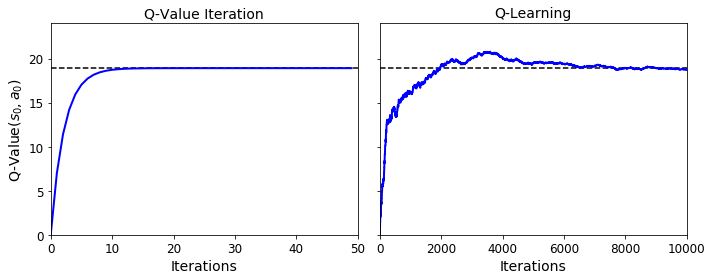

In [54]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot")

# 심층 Q-네트워크

DQN을 만들어 보죠. 상태가 주어지면 가능한 모든 행동에 대해서 행동을 플레이한 후 (하지만 결과를 보기 전에) 기대할 수 있는 할인된 미래 보상의 합을 추정합니다:

In [55]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

이 DQN을 사용해 행동을 선택하려면 가장 큰 예측 Q-가치를 가진 행동을 선택하면 됩니다. 하지만 에이전트가 환경을 탐험하려면 `epsilon` 확률로 랜덤한 행동을 선택합니다.

In [56]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

재생 메모리도 필요합니다. 여기에는 에이전트의 경험이 담겨 있습니다. 형식은 `(obs, action, reward, next_obs, done)`와 같습니다. `deque` 클래스를 사용할 수 있습니다(더 강력한 경험 재생의 구현을 위해 딥마인드의 [Reverb 라이브러리](https://github.com/deepmind/reverb)를 참고하세요):

In [57]:
from collections import deque

replay_memory = deque(maxlen=2000)

그리고 재생 메모리에서 경험을 샘플링하는 함수를 만듭니다. 이 함수는 5개의 넘파이 배열 `[states, actions, rewards, next_obs, dones]`을 반환합니다.

In [58]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

이제 DQN을 사용해 한 스텝을 플레이하는 함수를 만들고 경험을 재생 메모리에 기록할 수 있습니다:

In [59]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

마지막으로 재생 메모리에서 약간의 경험을 샘플링하고 훈련 스텝을 수행하는 함수를 만들어 보죠:

**노트**:
* 2판의 처음 세 번의 릴리스에는 `target_Q_values`를 열 벡터로 변환하는 `reshape()` 연산이 빠져있습니다(`loss_fn()`에서 필요합니다).
* 이 책은 학습률 1e-3을 사용하지만 아래 코드에서는 훈련이 크게 좋아지기 때문에 1e-2를 사용합니다. 또한 여러 가지 DQN의 학습률을 튜닝했습니다.

In [60]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

이제 모델을 훈련해 보죠!

In [61]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [62]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 200, eps: 0.010

Saving figure dqn_rewards_plot


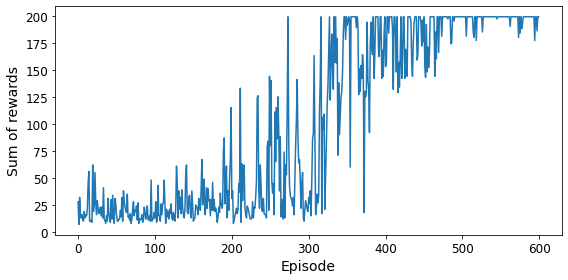

In [63]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [64]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

나쁘지 않네요! 😀

## 더블 DQN

In [65]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [66]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [67]:
replay_memory = deque(maxlen=2000)

In [68]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode >= 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 599, Steps: 55, eps: 0.0100

Saving figure double_dqn_rewards_plot


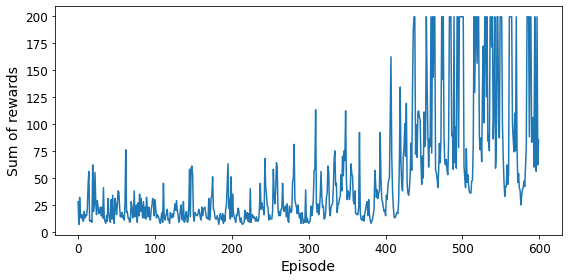

In [69]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [70]:
env.seed(43)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
   
plot_animation(frames)

# 듀얼링 더블 DQN

In [71]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [72]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [73]:
replay_memory = deque(maxlen=2000)

In [74]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 200, eps: 0.010

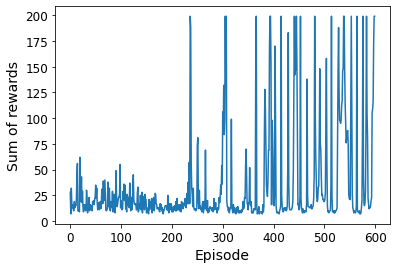

In [75]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [76]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

매우 안정적인 에이전트같습니다!

In [77]:
env.close()

# TF-Agents를 사용해 브레이크아웃 게임하기

TF-Agents를 사용해 브레이크아웃 플레이를 학습하는 에이전트를 만들어 보죠. 심층 Q-러닝 알고리즘을 사용하겠습니다. 따라서 이전 구현과 구성 요소를 쉽게 비교할 수 있습니다. 하지만 TF-Agents에는 다른 (그리고 복잡한) 알고리즘을 많이 구현되어 있습니다!

## TF-Agents 환경

In [78]:
tf.random.set_seed(42)
np.random.seed(42)

In [79]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [80]:
env.gym

In [81]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [82]:
env.step(1) # Fire

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

Saving figure breakout_plot


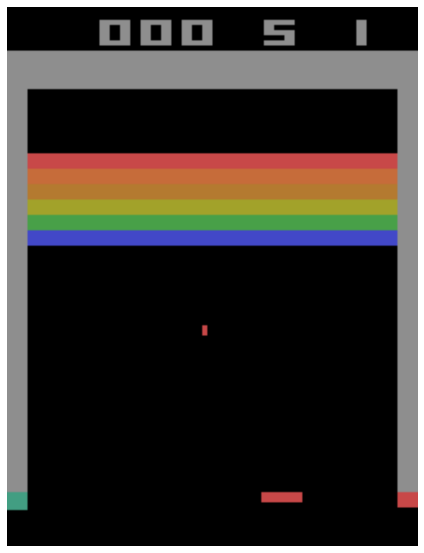

In [83]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [84]:
env.current_time_step()

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

## 환경 스펙

In [85]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [86]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [87]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

## 환경 래퍼

TF-Agents 래퍼로 TF-Agents 환경을 감쌀 수 있습니다:

In [88]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [89]:
repeating_env.unwrapped

가능한 래퍼 목록은 다음과 같습니다:

In [90]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls to the given environment.
RunStats                    Wrapp

`suite_gym.load()`는 TF-Agents 환경 래퍼와 짐 환경 래퍼로 환경을 만들고 래핑합니다(후자가 먼저 적용됩니다).

In [91]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [92]:
limited_repeating_env

In [93]:
limited_repeating_env.unwrapped

아타리 브레이크아웃 환경을 만들고 기본 아타리 전처리 단계를 적용합니다:

**경고**: 브레이크아웃은 게임 시작과 죽을 때마다 FIRE 버튼을 눌러야 합니다. 처음에는 FIRE 버튼을 누르는 것이 빨리 지는 것처럼 보이기 때문에 에이전트가 이를 배우는데 매우 오랜 시간이 걸릴 수 있습니다. 훈련 속도를 높이려면 `AtariPreprocessing` 래퍼 클래스를 상속하여 `AtariPreprocessingWithAutoFire`를 만들고 사용합니다. 이 클래스는 게임 시작과 말이 죽을 때마다 자동으로 FIRE(즉 플레이 행동 1)를 누릅니다. 일반적인 `AtariPreprocessing` 래퍼를 사용한 책의 코드와 다른 점입니다.

In [94]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            super().step(1) # FIRE to start after life lost
        return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4])

In [95]:
env

몇 개의 스텝을 플레이하고 어떻게 동작하는지 확인합니다:

In [96]:
env.seed(42)
env.reset()
for _ in range(4):
    time_step = env.step(3) # 왼쪽

In [97]:
def plot_observation(obs):
    # 컬러 채널이 3개이기 때문에 4 프레임을 출력할 수 없습니다.
    # 따라서 현재 프레임과 다른 프레임의 평균 값을 뺀 차이를 계산합니다.
    # 그다음 이 차이를 현재 프레임의 빨강과 파랑 채널에 더해서 보라 색을 구합니다.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure preprocessed_breakout_plot


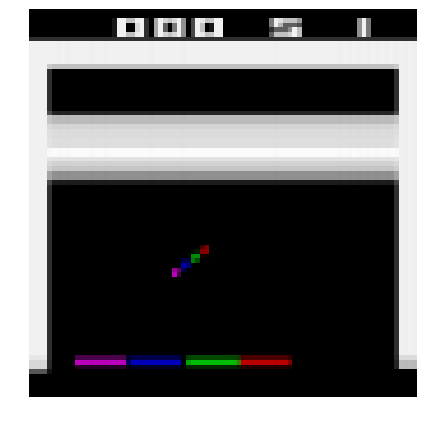

In [98]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

파이썬 환경을 TF 환경으로 변환합니다:

In [99]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## DQN 만들기

관측을 정규화하는 작은 클래스를 만듭니다. 이미지를 0~255 사이의 바이트로 저장하는 것이 램을 적게 사용하지만 신경망에는 0.0~1.0 사이의 실수를 전달해야 합니다:

Q-네트워크를 만듭니다:

In [100]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

DQN 에이전트를 만듭니다:

In [101]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

재생 버퍼를 만듭니다(램을 많이 사용하기 때문에 메모리 부족 에러가 나오면 버퍼 크기를 줄이세요):

**경고**: (책과 달리) 1,000,000이 아니고 100,000 크기의 재생 버퍼를 사용합니다. 대부분의 경우 메모리 부족 에러가 나기 때문입니다.

In [102]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000) # OOM 에러가 나면 줄이세요

replay_buffer_observer = replay_buffer.add_batch

호출 횟수를 카운트하고 출력하는 간단한 사용자 정의 옵저버를 만듭니다(하나의 스텝으로 카운트하지 않는 두 에피소드 사이의 경계는 제외합니다):

In [103]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

훈련 측정 지표를 추가해 보죠:

In [104]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [105]:
train_metrics[0].result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [106]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


수집 드라이버를 만듭니다:

In [107]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

훈련 전에 초기 경험을 수집합니다:

In [108]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

20000/20000

3개의 스텝을 가진 2개의 서브 에피소드를 샘플링해서 출력해 보죠:

**노트**: `replay_buffer.get_next()`는 deprecated 되었습니다. 대신 `replay_buffer.as_dataset(..., single_deterministic_pass=False)`를 사용해야 합니다.

In [109]:
tf.random.set_seed(9) # 에피소드 끝에서 경로 샘플을 보여주기 위해

#trajectories, buffer_info = replay_buffer.get_next( # get_next() is deprecated
#    sample_batch_size=2, num_steps=3)

trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))

In [110]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [111]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [112]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [113]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

Saving figure sub_episodes_plot


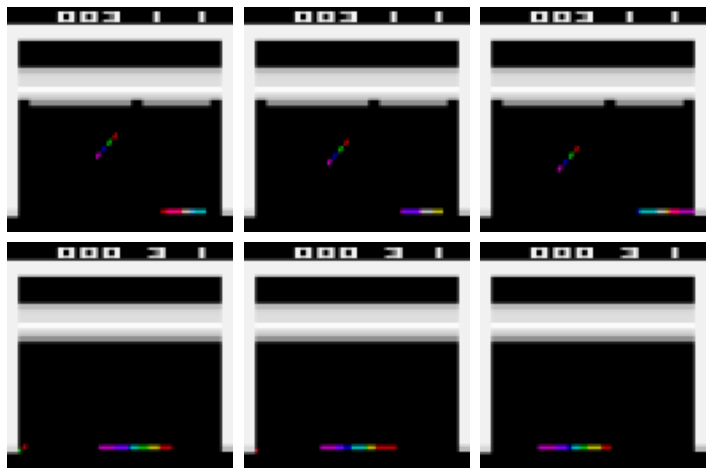

In [114]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

이제 데이터셋을 만들어 보죠:

In [115]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

성능을 높이기 위해 메인 함수를 TF 함수로 변환합니다:

In [116]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

이제 메인 루프를 실행할 준비가 되었습니다!

In [117]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

다음 셀에서 에이전트를 50,000 스텝 동안 훈련합니다. 그다음 다음 셀을 실행하여 에이전트의 동작을 살펴 보겠습니다. 이 두 셀을 원하는만큼 많이 실행할 수 있습니다. 에이전트는 점점 향상될 것입니다! 에이전트가 어느정도 좋은 동작을 수행하려면 200,000 반복 정도 걸릴 것입니다.

In [118]:
train_agent(n_iterations=50000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


998 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 4004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 184.1999969482422


1998 loss:0.00181

INFO:absl: 
		 NumberOfEpisodes = 48
		 EnvironmentSteps = 8004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 182.39999389648438


2998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 12004


<<244 more lines>>


		 NumberOfEpisodes = 1003
		 EnvironmentSteps = 176004
		 AverageReturn = 5.099999904632568
		 AverageEpisodeLength = 246.5


44998 loss:0.00165

INFO:absl: 
		 NumberOfEpisodes = 1019
		 EnvironmentSteps = 180004
		 AverageReturn = 5.199999809265137
		 AverageEpisodeLength = 256.6000061035156


45998 loss:0.00136

INFO:absl: 
		 NumberOfEpisodes = 1035
		 EnvironmentSteps = 184004
		 AverageReturn = 4.599999904632568
		 AverageEpisodeLength = 252.1999969482422


46998 loss:0.00100

INFO:absl: 
		 NumberOfEpisodes = 1050
		 EnvironmentSteps = 188004
		 AverageReturn = 5.699999809265137
		 AverageEpisodeLength = 276.5


47998 loss:0.00116

INFO:absl: 
		 NumberOfEpisodes = 1063
		 EnvironmentSteps = 192004
		 AverageReturn = 5.900000095367432
		 AverageEpisodeLength = 296.3999938964844


48998 loss:0.00049

INFO:absl: 
		 NumberOfEpisodes = 1077
		 EnvironmentSteps = 196004
		 AverageReturn = 7.800000190734863
		 AverageEpisodeLength = 308.29998779296875


49999 loss:0.00073

In [119]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

에이전트를 친구에게 보여주고 싶어서 애니메이션 GIF로 저장하고 싶다면 다음 방법을 사용하세요:

In [120]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [121]:
%%html
<img src="images/rl/breakout.gif" />

# 추가 내용

## Deque vs 로테이팅 리스트

`deque` 클래스는 추가(append)가 빠르지만 랜덤 접근은 느립니다(재생 메모리가 클 경우):

In [122]:
from collections import deque
np.random.seed(42)

mem = deque(maxlen=1000000)
for i in range(1000000):
    mem.append(i)
[mem[i] for i in np.random.randint(1000000, size=5)]

[121958, 671155, 131932, 365838, 259178]

In [123]:
%timeit mem.append(1)

47.4 ns ± 3.02 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [124]:
%timeit [mem[i] for i in np.random.randint(1000000, size=5)]

182 µs ± 6.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


또는 다음의 `ReplayMemory` 클래스 같은 로테이팅 리스트를 사용할 수 있습니다. 재생 메모리가 클 경우 랜덤 접근이 더 빠릅니다:

In [125]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=np.object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [126]:
mem = ReplayMemory(max_size=1000000)
for i in range(1000000):
    mem.append(i)
mem.sample(5)

array([757386, 904203, 190588, 595754, 865356], dtype=object)

In [127]:
%timeit mem.append(1)

519 ns ± 17.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [128]:
%timeit mem.sample(5)

9.24 µs ± 227 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## 사용자 정의 TF-Agents 환경 만들기

사용자 정의 TF-Agents 환경을 만들려면 `PyEnvironment` 클래스를 상속하는 클래스를 만들고 몇 개의 메서드를 구현해야 합니다. 예를 들어 다음과 같은 환경은 간단한 4x4 그리드를 표현합니다. 에이전트가 한쪽 코너 (0,0)에서 시작하여 반대쪽 코너 (3,3)으로 이동해야 합니다. 에이전트가 목적지에 도착하면 에피소드가 끝납니다(+10 보상을 받습니다). 또는 에이전트가 경계를 벗어나면 끝납니다(-1 보상). 행동은 위(0), 아래(1), 왼쪽(2), 오른쪽(3)이 가능합니다.

In [129]:
class MyEnvironment(tf_agents.environments.py_environment.PyEnvironment):
    def __init__(self, discount=1.0):
        super().__init__()
        self._action_spec = tf_agents.specs.BoundedArraySpec(
            shape=(), dtype=np.int32, name="action", minimum=0, maximum=3)
        self._observation_spec = tf_agents.specs.BoundedArraySpec(
            shape=(4, 4), dtype=np.int32, name="observation", minimum=0, maximum=1)
        self.discount = discount

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros(2, dtype=np.int32)
        obs = np.zeros((4, 4), dtype=np.int32)
        obs[self._state[0], self._state[1]] = 1
        return tf_agents.trajectories.time_step.restart(obs)

    def _step(self, action):
        self._state += [(-1, 0), (+1, 0), (0, -1), (0, +1)][action]
        reward = 0
        obs = np.zeros((4, 4), dtype=np.int32)
        done = (self._state.min() < 0 or self._state.max() > 3)
        if not done:
            obs[self._state[0], self._state[1]] = 1
        if done or np.all(self._state == np.array([3, 3])):
            reward = -1 if done else +10
            return tf_agents.trajectories.time_step.termination(obs, reward)
        else:
            return tf_agents.trajectories.time_step.transition(obs, reward,
                                                               self.discount)

행동과 관측 스펙은 일반적으로 `tf_agents.spec` 패키지에 있는 `ArraySpec`이나 `BoundedArraySpec`의 인스턴스입니다(이 패키지에 있는 다른 스펙도 살펴 보세요). 선택적으로 `render()` 메서드, 자원을 해제하기 위한 `close()` 메서드를 정의할 수도 있습니다. 또한 `reward`와 `discount`를 32비트 실수 스칼라로 사용하고 싶지 않다면 `time_step_spec()` 메서드를 정의할 수 있습니다. 베이스 클래스는 현재 타임 스텝을 추적하므로 `reset()`, `step()` 대신에 `_reset()`, `_step()`을 구현해야 합니다.

In [130]:
my_env = MyEnvironment()
time_step = my_env.reset()
time_step

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32))

In [131]:
time_step = my_env.step(1)
time_step

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32))

# 연습문제 해답

## 1. to 7.

부록 A 참조

## 8.
_연습문제: 정책 그레이디언트를 사용해 OpenAI 짐의 LunarLander-v2 환경을 해결해보세요. 이를 위해 Box2D 패키지를 설치해야 합니다(`%pip install -U gym[box2d]`)._

먼저 LunarLander-v2 환경을 만들어 보죠:

In [240]:
env = gym.make("LunarLander-v2")

입력은 8차원입니다:

In [241]:
env.observation_space

Box(-inf, inf, (8,), float32)

In [242]:
env.seed(42)
obs = env.reset()
obs

array([-0.00499964,  1.4194578 , -0.506422  ,  0.37943238,  0.00580009,
        0.11471219,  0.        ,  0.        ], dtype=float32)

[소스 코드](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py)를 보면 8D 관측(x, y, h, v, a, w, l, r)이 각각 다음에 해당합니다:
* x,y: 우주선의 좌표. (0, 1.4) 근처의 랜덤한 위치에서 시작하고 (0, 0)에 있는 목적지 근처에 내려야 합니다.
* h,v: 우주선의 수평, 수직 속도. 랜덤한 적은 속도로 시작합니다.
* a,w: 우주선의 각도와 각속도.
* l,r: 왼쪽이나 오른쪽 다리가 땅에 닿았는지(1.0) 아닌지(0.0) 여부.

행동 공간은 이산적이며 4개의 가능한 행동이 있습니다:

In [243]:
env.action_space

Discrete(4)

[LunarLander-v2 설명](https://gym.openai.com/envs/LunarLander-v2/)을 보면 이 행동은 다음과 같습니다:
* 아무것도 하지 않음
* 왼쪽 방향 엔진을 켬
* 주 엔진을 켬
* 오른쪽 방향 엔진을 켬

(행동마다 하나씩) 4개의 출력 뉴런을 가진 간단한 정책 네트워크를 만들어 보죠:

In [244]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(n_outputs, activation="softmax"),
])

출력 층에 CartPole-v1 환경처럼 시그모이드 활성화 함수를 사용하지 않고 대신에 소프트맥스 활성화 함수를 사용합니다. CartPole-v1 환경은 두 개의 행동만 있어서 이진 분류 모델이 맞기 때문입니다. 하지만 두 개 이상의 행동이 있으므로 다중 분류 모델이 됩니다.

그다음 CartPole-v1 정책 그레이디언트 코드에서 정의한 `play_one_step()`와 `play_multiple_episodes()` 함수를 재사용합니다. 하지만 다중 분류 모델에 맞게 `play_one_step()`를 조금 수정하겠습니다. 그다음 수정된 `play_one_step()` 를 호출하고, 우주선이 최대 스텝 횟수 전에 랜딩하지 못하면 (또는 부서지면) 큰 페널티를 부여하도록 `play_multiple_episodes()` 함수를 수정합니다.

In [245]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(action[0, 0].numpy())
    return obs, reward, done, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = lander_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

앞에서와 동일한 `discount_rewards()`와 `discount_and_normalize_rewards()` 함수를 사용합니다:

In [246]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

이제 몇 개의 하이퍼파라미터를 정의합니다:

In [247]:
n_iterations = 200
n_episodes_per_update = 16
n_max_steps = 1000
discount_rate = 0.99

여기서도 다중 분류 모델이기 때문에 이진 크로스 엔트로피가 아니라 범주형 크로스 엔트로피를 사용해야 합니다. 또한 `lander_play_one_step()` 함수가 클래스 확률이 아니라 클래스 레이블로 타깃을 설정하기 때문에 `sparse_categorical_crossentropy()` 손실 함수를 사용해야 합니다:

In [248]:
optimizer = keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

모델을 훈련할 준비가 되었네요. 시작해 보죠!

In [249]:
env.seed(42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print("\rIteration: {}/{}, mean reward: {:.1f}  ".format(
        iteration + 1, n_iterations, mean_reward), end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 200/200, mean reward: 134.2  

학습 곡선을 그려 보겠습니다:

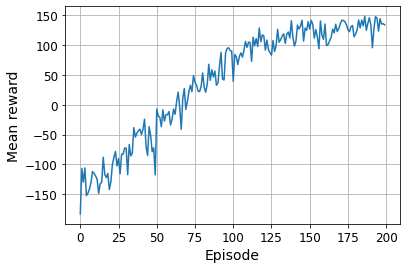

In [250]:
import matplotlib.pyplot as plt

plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

결과를 확인해 보죠!

In [257]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make("LunarLander-v2")
    env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0, 0].numpy())
        if done:
            break
    env.close()
    return frames

In [264]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

꽤 괜찮군요. 더 오래 훈련하거나 하이퍼파라미터를 튜닝하여 200을 넘을 수 있는지 확인해 보세요.

## 9.
_연습문제: 알고리즘에 상관없이 TF-Agents를 사용해 SpaceInvaders-v4 환경에서 사람을 능가하는 에이전트를 훈련해보세요._

`"Breakout-v4"`를 `"SpaceInvaders-v4"`로 바꾸고 [TF Agents를 사용해 브레이크아웃 게임하기](#TF-Agents%EB%A5%BC-%EC%82%AC%EC%9A%A9%ED%95%B4-%EB%B8%8C%EB%A0%88%EC%9D%B4%ED%81%AC%EC%95%84%EC%9B%83-%EA%B2%8C%EC%9E%84%ED%95%98%EA%B8%B0) 절에 있는 단계를 따라해 보세요. 하지만 몇 가지를 바꾸어야 합니다. 예를 들어 스페이스 인베이더 게임은 게임을 시작할 때 FIRE 버튼을 누를 필요가 없습니다. 대신 플레이어의 레이저 캐논이 몇 초간 깜빡거린 다음 자동으로 게임이 시작됩니다. 성능을 높이려면 에피소드를 시작할 때와 죽을 때마다 깜빡임 단계(약 40 스텝 동안 지속됩니다)를 건너 뛸 수 있습니다. 사실 이 단계에서는 아무것도 할 수 없고 아무것도 움직이지 않습니다. 건너 뛰는 방법은 `AtariPreprocessingWithAutoFire` 래퍼 대신에 다음과 같은 사용자 정의 환경 래퍼를 사용하는 것입니다:

In [132]:
class AtariPreprocessingWithSkipStart(AtariPreprocessing):
    def skip_frames(self, num_skip):
        for _ in range(num_skip):
          super().step(0) # NOOP for num_skip steps
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        self.skip_frames(40)
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            self.skip_frames(40)
        return obs, rewards, done, info

또한 전처리된 이미지가 게임 플레이에 관한 충분한 정보를 담고 있는지 항상 확인해야 합니다. 예를 들어, 낮은 해상도에도 불구하고 레이저 캐논과 에일리언에서 발사된 총알은 항상 보여야 합니다. 이 경우에 브레이크아웃에서 수행했던 전처리가 스페이스 인베이더에도 잘 맞습니다. 하지만 다른 게임에서는 항상 확인해봐야 합니다. 이를 위해 에이전트가 랜덤하게 플레이하게 잠시 놔두고 전처리된 프레임을 기롭한 다음 애니메이션을 플레이하여 게임 플레이가 잘 보이는지 확인하세요.

좋은 성능을 얻으려면 에이전트를 꽤 오랜 시간 동안 훈련해야 합니다. 안타깝게도 DQN 알고리즘은 스페이스 인베이더에서 사람을 뛰어 넘는 수준을 달성할 수 없습니다. 사람은 이 게임에서 효율적인 장기 전략을 학습할 수 있지만 DQN은 매우 짧은 전략만 학습할 수 있습니다. 하지만 지난 몇 년간 많은 발전이 있었습니다. 이제는 많은 RL 알고리즘이 이 게임에서 전문가의 수준을 뛰어 넘을 수 있습니다. [State-of-the-Art for Space Invaders on paperswithcode.com](https://paperswithcode.com/sota/atari-games-on-atari-2600-space-invaders)를 참고하세요.

## 10.
_연습문제: 10만 원 정도 여유가 있다면 라즈베리 파이 3와 저렴한 로보틱스 구성품을 구입해 텐서플로를 설치하고 실행할 수 있습니다! 예를 들어 루카스 비월드의 재미있는 [포스트](https://homl.info/2)를 참고하거나, GoPiGo42나 BrickPi43를 둘러보세요. 간단한 작업부터 시작해보세요. 예를 들어 (조도 센서가 있다면) 로봇이 밝은 쪽으로 회전하거나 (초음파 센서가 있다면) 가까운 물체가 있는 쪽으로 움직이도록 해보세요. 그다음 딥러닝을 사용해보세요. 예를 들어 로봇에 카메라가 있다면 객체 탐지 알고리즘을 구현해 사람을 감지하고 가까이 다가가게 만들 수 있습니다. 강화 학습을 사용해 목표를 달성하기 위해 모터 사용법을 스스로 학습할 수도 있습니다._

이제 여러분 차례입니다. 도전적이고 창의적으로, 무엇보다도 인내심을 가지고 한 발씩 나아가세요. 여러분은 할 수 있습니다!